## Requirements

In [1]:
from lightgbm.sklearn import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

sns.set()

import warnings
warnings.filterwarnings("ignore")

Load dataset

In [2]:
data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

# EDA

In [3]:
data.head()

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,...,P19,P20,P21,P22,P23,P24,P25,P26,P27,target
0,-6536978109522202983,0,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,...,15.400000,4.82,8.911111,200.0,0.000000,4.820000,0.333333,6712.0,0.333333,0.0
1,-6536978109522202983,1,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,...,17.016667,4.82,8.292754,510.0,0.000000,4.820000,0.652174,4873.0,0.391304,0.0
2,-6536978109522202983,2,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,...,41.100000,4.82,9.753030,190.0,0.000000,4.820000,0.500000,2175.0,0.181818,0.0
3,-6536978109522202983,3,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,...,33.850000,4.82,10.520614,382.0,0.026316,4.814737,0.447368,4093.0,0.394737,0.0
4,-1744017237843019509,0,0.051282,1.0,0.014363,0.018308,0.037632,0.0000,0.180246,0.103449,...,31.866667,4.94,9.438406,777.0,0.021739,4.908478,0.673913,1296.0,0.239130,0.0


In [4]:
data.describe()

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,...,P19,P20,P21,P22,P23,P24,P25,P26,P27,target
count,3.086000e+04,30860.000000,30812.000000,30812.000000,23760.000000,23760.000000,23760.000000,23760.000000,23760.000000,23760.000000,...,27947.000000,27946.000000,27947.000000,27946.000000,27947.000000,27946.000000,27947.000000,27946.000000,27946.000000,30860.000000
mean,5.880459e+16,1.500000,0.086103,1.917175,0.046198,0.046558,0.010059,0.008308,0.152373,0.111035,...,26.592387,4.944650,9.013416,323.196450,0.008797,4.940130,0.492355,3266.263186,0.344434,0.173169
std,5.305951e+18,1.118052,0.116918,2.962384,0.074886,0.080221,0.030413,0.049233,0.136181,0.104658,...,25.158699,0.060288,2.901414,146.382184,0.040291,0.063075,0.329794,3144.738593,0.257145,0.378400
min,-9.217316e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,4.240000,0.141667,48.000000,0.000000,4.217500,0.000000,0.000000,0.000000,0.000000
25%,-4.443360e+18,0.750000,0.000000,0.000000,0.000000,0.002933,0.000000,0.000000,0.050836,0.039541,...,15.666667,4.920000,7.479428,223.000000,0.000000,4.920000,0.184211,1423.000000,0.140187,0.000000
50%,6.482893e+16,1.500000,0.047619,1.000000,0.020706,0.023266,0.000000,0.000000,0.125738,0.089358,...,20.466667,4.960000,8.477667,290.000000,0.000000,4.960000,0.530435,2293.000000,0.294118,0.000000
75%,4.655320e+18,2.250000,0.128205,2.000000,0.054194,0.053769,0.007143,0.000000,0.215331,0.150164,...,30.233333,4.990000,9.835913,390.000000,0.000000,4.980000,0.780488,3973.750000,0.500000,0.000000
max,9.222566e+18,3.000000,0.823529,28.000000,0.806543,0.938948,0.804446,0.862319,0.993363,1.000000,...,486.150000,5.000000,71.516667,2049.000000,1.000000,5.000000,1.000000,120092.000000,1.000000,1.000000


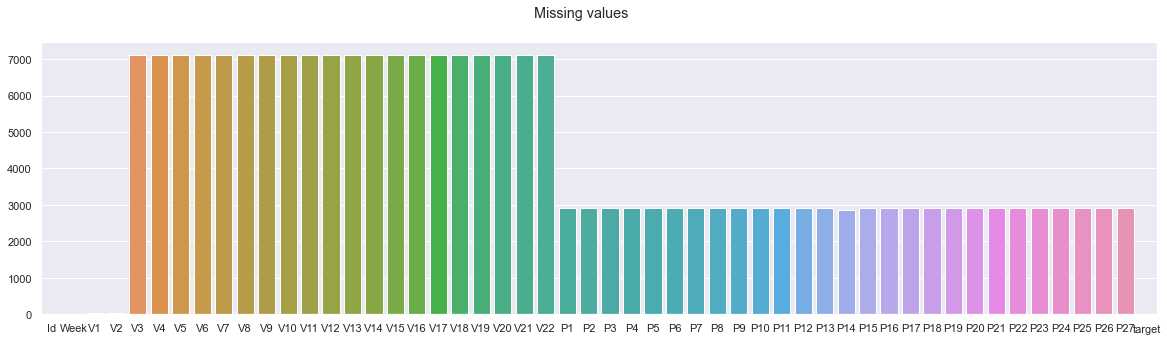

In [5]:
missing = data.isna().sum()
plt.figure(figsize=(20, 5))
sns.barplot(x=missing.index, y=missing.values)
plt.suptitle('Missing values')
plt.show()

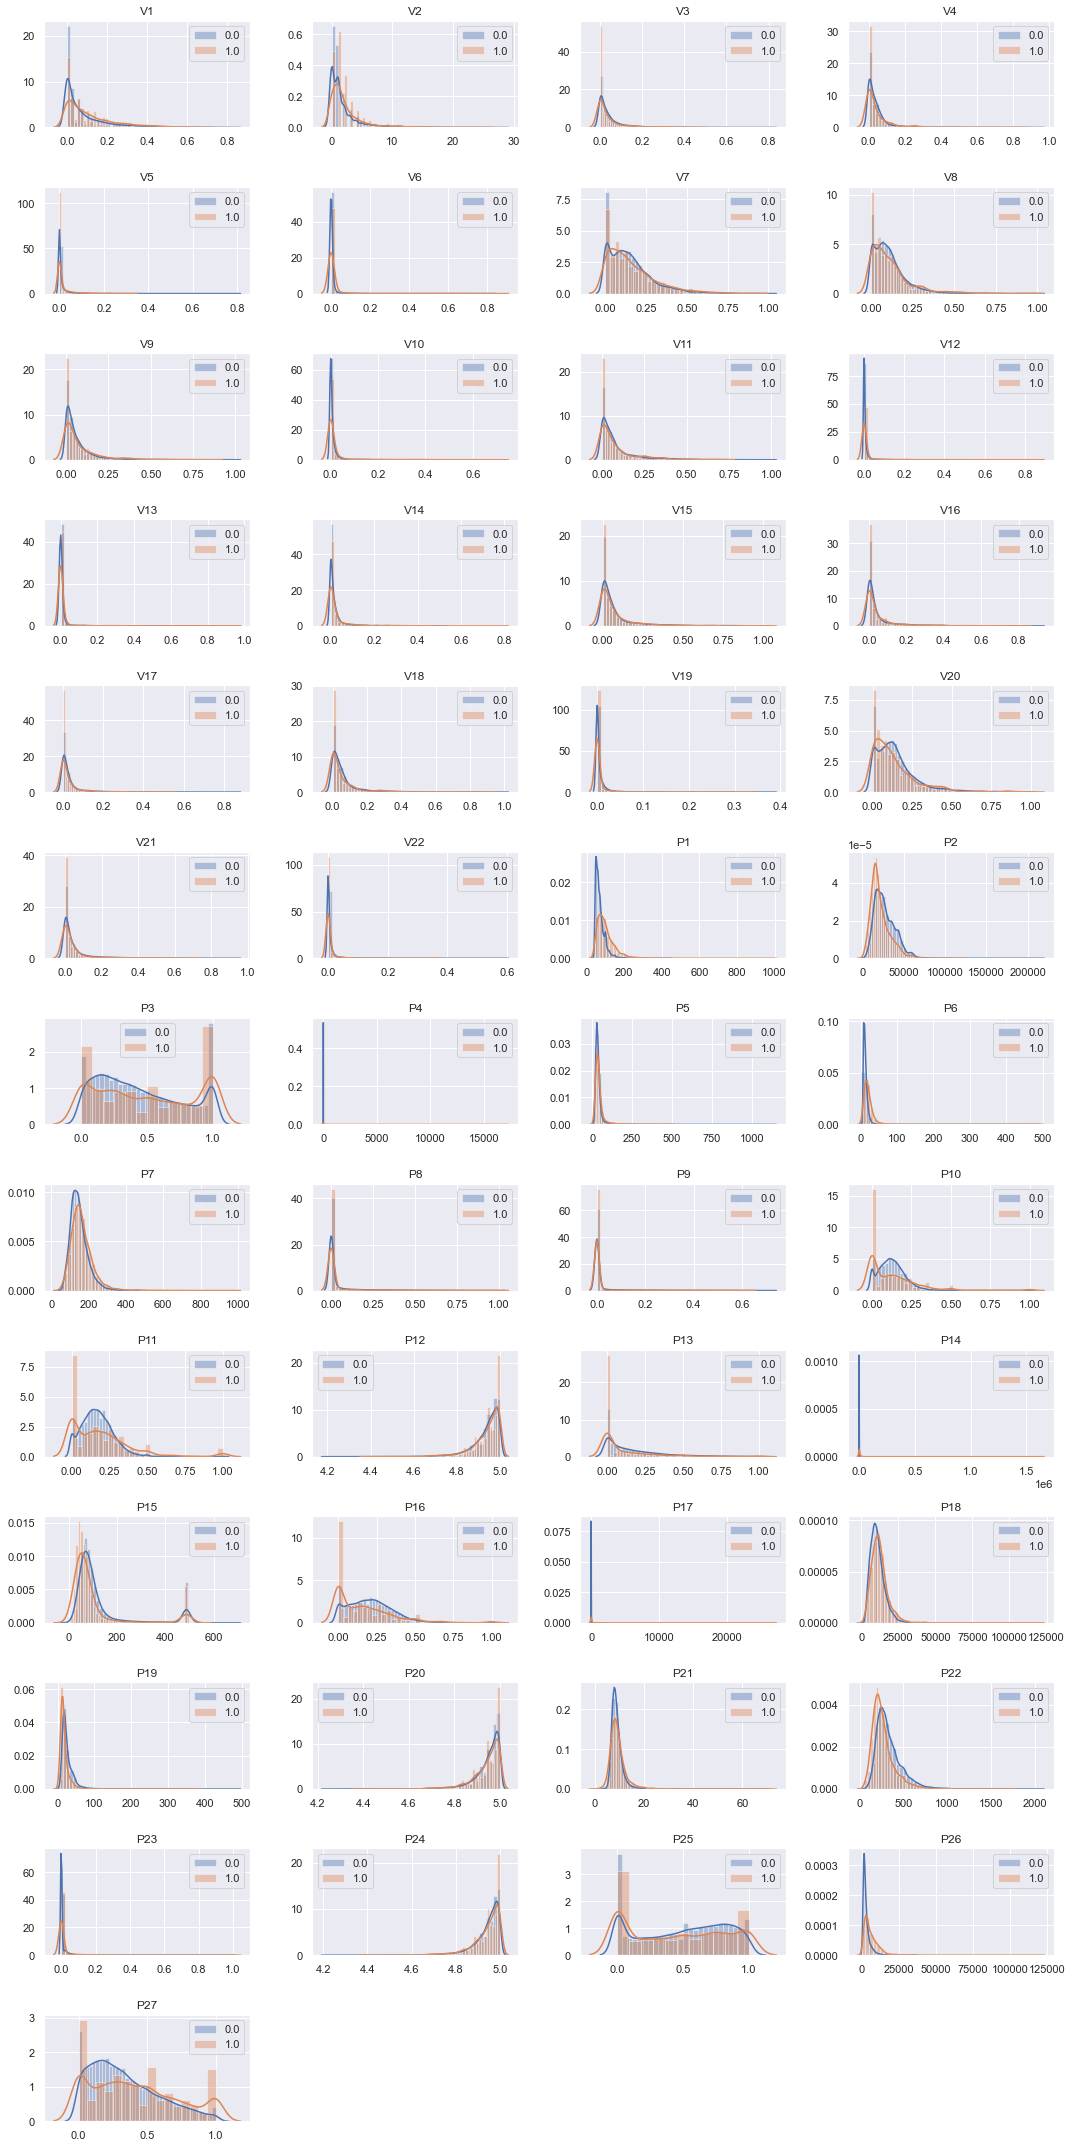

In [6]:
fig, axes = plt.subplots(13, 4, figsize=(15, 30))
axes = axes.flatten()

for c, ax in zip(data.drop(['Id', 'Week', 'target'], axis=1).columns, axes):
    data.groupby('target')[c].apply(lambda x: sns.distplot(x, ax=ax, label=x.name))
    ax.set_title(c)
    ax.legend()
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.tight_layout()

for ax in axes[-3:]:
    ax.set_axis_off()

plt.show()

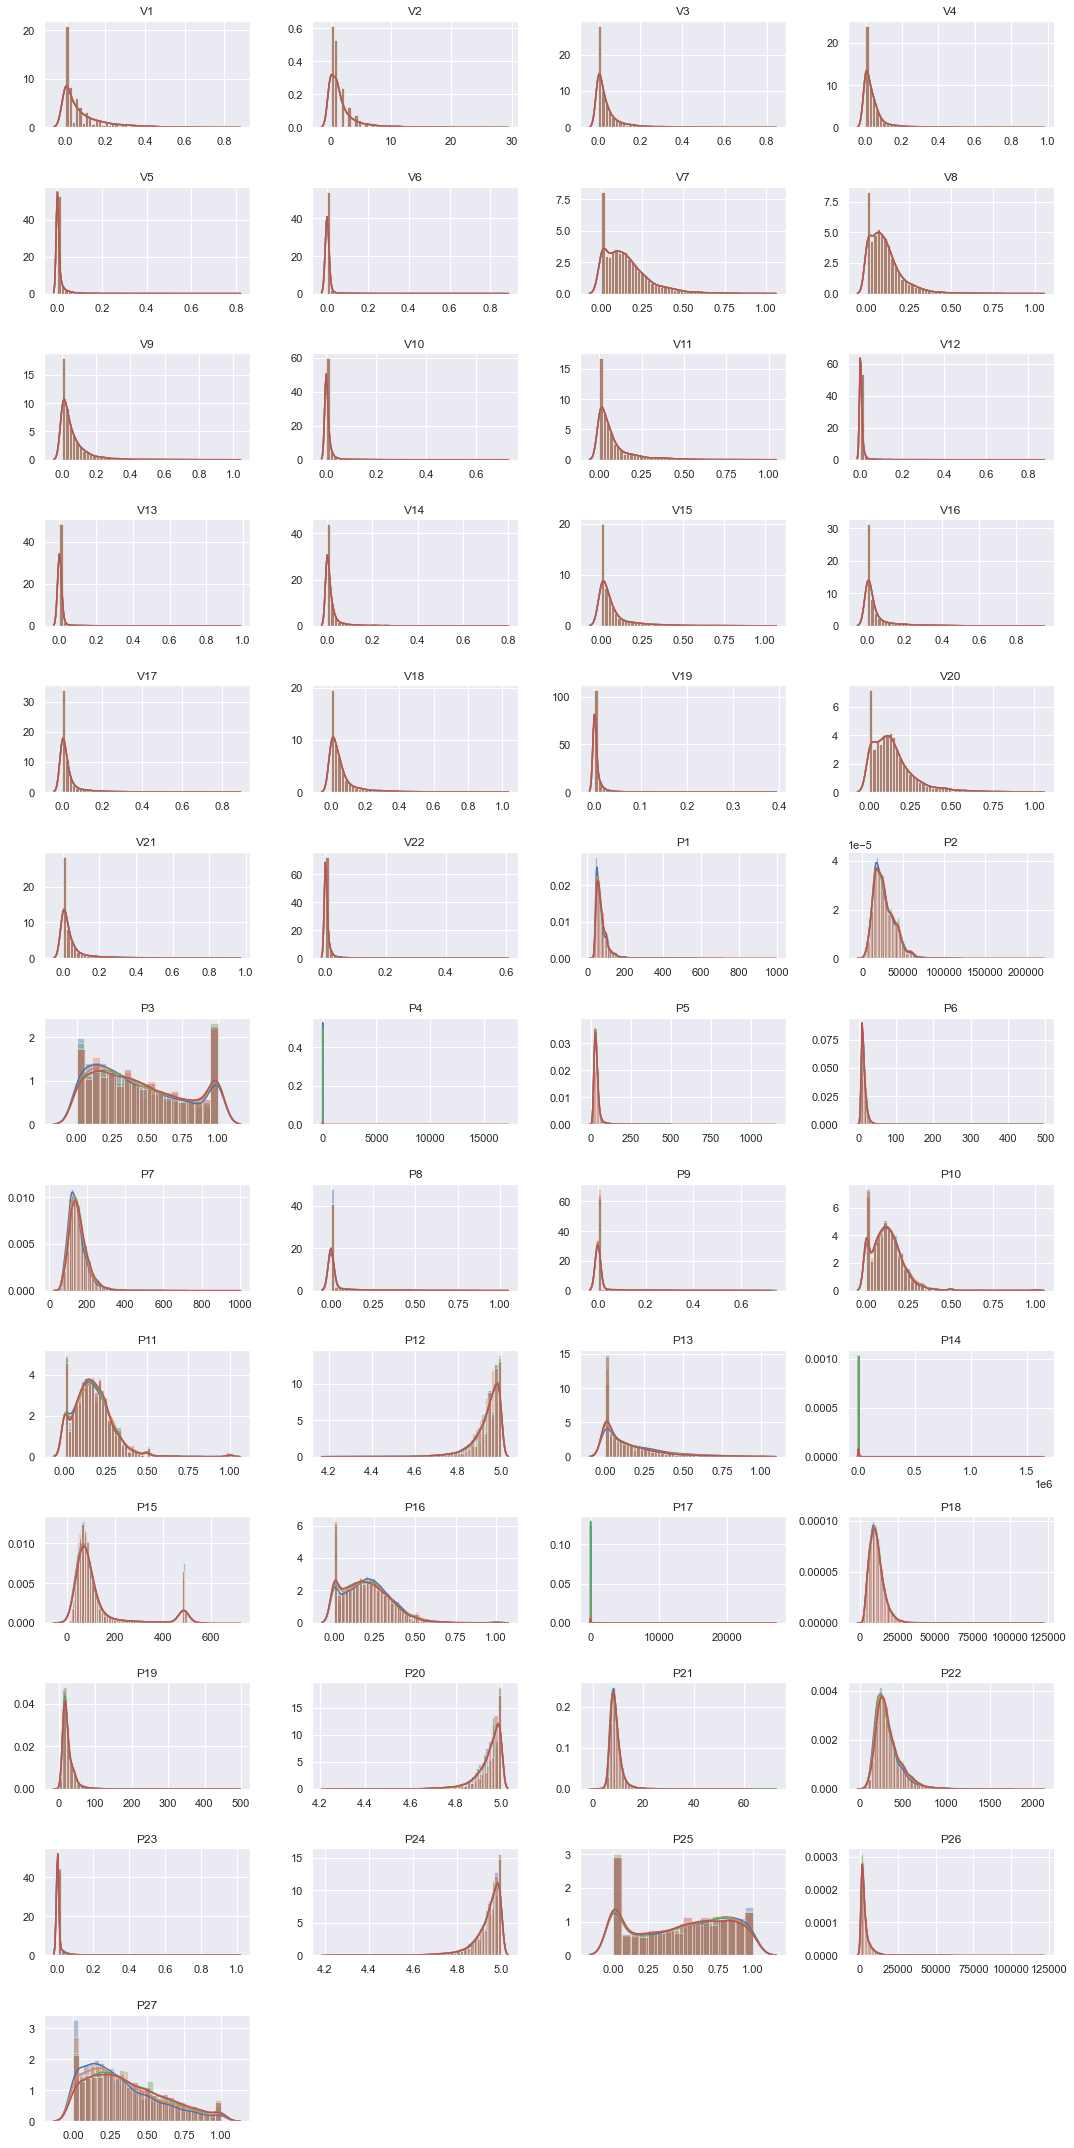

In [7]:
fig, axes = plt.subplots(13, 4, figsize=(15, 30))
axes = axes.flatten()

for c, ax in zip(data.drop(['Id', 'Week', 'target'], axis=1).columns, axes):
    data.groupby('Week')[c].apply(lambda x: sns.distplot(x, ax=ax, label=x.name))
    ax.set_title(c)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.tight_layout()

for ax in axes[-3:]:
    ax.set_axis_off()

plt.show()

All drivers who left the service, did it in the first week

In [8]:
tmp = data[data["target"]==1].groupby("Id")["target"].sum()
np.all(tmp != 4)

False

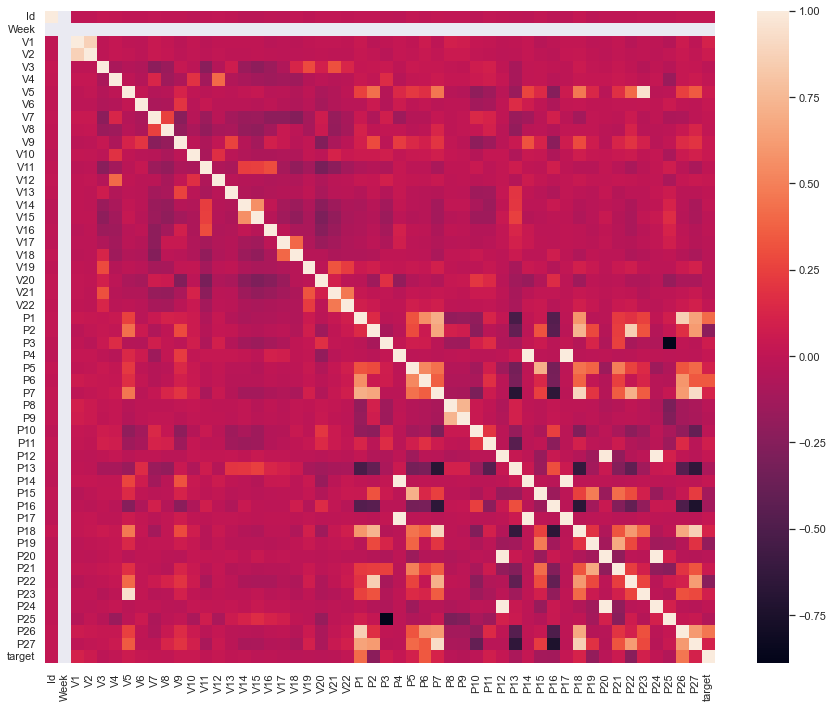

In [12]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr())
plt.show()

Group data by Id. Compute mean features of groups

In [10]:
data = data.sort_values(['Id', 'Week'])
data = data.groupby(['Id']).agg(np.nanmean).reset_index()

test_data = test_data.sort_values(['Id', 'Week'])
test_data = test_data.groupby(['Id']).agg(np.nanmean).reset_index()

Split into features and target

In [11]:
X = data.drop(['Id', 'Week', 'target'], axis=1)
y = data['target']

Performance of tested models. Score is calculated for hard predictions (0 or 1)

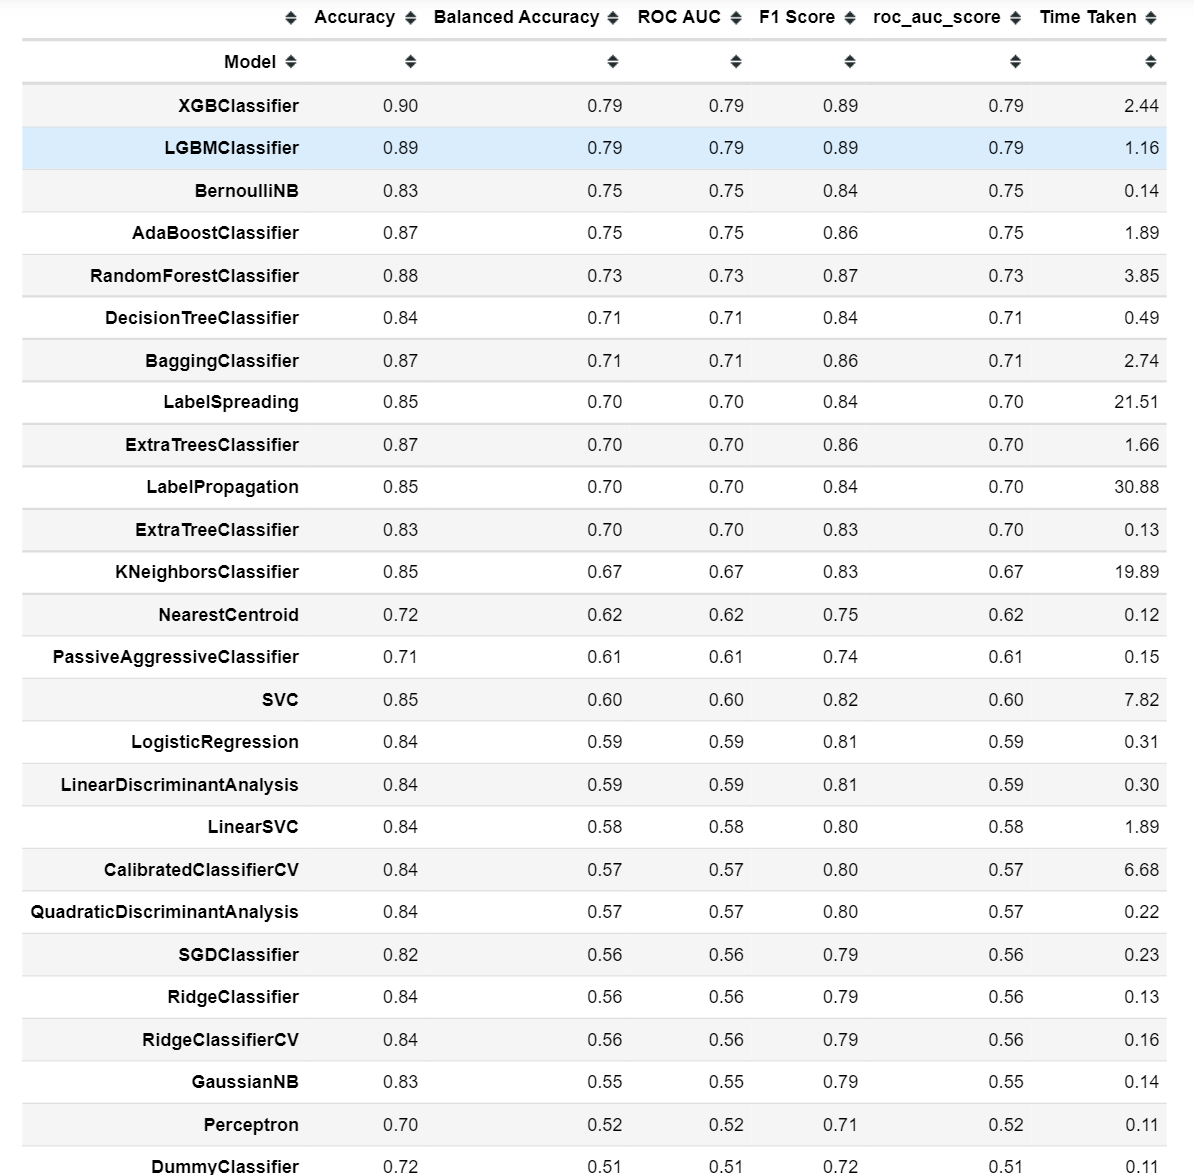

# Tuning, training, prediction

Take LightGBMClassifier as as baseline. Perform hyperparameter tuning with cross-validation using optuna (5 folds)

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.005,
    'random_state': 42,
    'n_jobs': 16,
    'verbosity': -1
}

tuner = lgb.LightGBMTunerCV(params, lgb.Dataset(X, y), verbose_eval=500, num_boost_round=1000, 
                            optuna_seed=42)
tuner.run()

Get Out-of-Fold predictions using tuned hyperparameters (10 folds)

In [ ]:
X = data.drop(['Id', 'Week', 'target'], axis=1)
y = data['target']

folds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
predictions = np.zeros(len(test_data))
for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    clf = LGBMClassifier(n_estimators=5000, **params, **tuner.study.best_trial.params)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='auc', early_stopping_rounds=250, verbose=0)
    
    y_preds = clf.predict_proba(X_valid)[:,1]
    predictions += clf.predict_proba(test_data.drop(['Id', 'Week'], axis=1))[:,1] / folds.n_splits 
    
    print(f'Fold {fold + 1}, Validation AUC = {roc_auc_score(y_valid, y_preds)}')

# Submission

In [ ]:
submission = pd.DataFrame(test_data['Id'])
submission['Predicted'] = predictions
submission = submission.set_index('Id')
submission.to_csv('submission.csv')